In [17]:
from gradio_client import Client, handle_file   
# импорт contenxtmanager
from contextlib import contextmanager
import time


In [18]:
@contextmanager
def timer():
    start = time.time()
    yield
    end = time.time()
    print(f"Cell execution time: {end - start:.4f} seconds")


In [2]:
DATA_BASE_DIR = "/home/jovyan/names"

In [3]:
# Get all jpg files
def get_all_files():
    files = []
    for root, dirs, filenames in os.walk(DATA_BASE_DIR):
        for filename in filenames:
            if filename.endswith(".jpg"):
                files.append(os.path.join(root, filename))
    return files

In [4]:
all_files = get_all_files()
all_files[:10]

['/home/jovyan/names/267.jpg',
 '/home/jovyan/names/879.jpg',
 '/home/jovyan/names/102.jpg',
 '/home/jovyan/names/861.jpg',
 '/home/jovyan/names/785.jpg',
 '/home/jovyan/names/162.jpg',
 '/home/jovyan/names/490.jpg',
 '/home/jovyan/names/872.jpg',
 '/home/jovyan/names/39.jpg',
 '/home/jovyan/names/797.jpg']

In [5]:
client = Client("http://api:7860/")

Loaded as API: http://api:7860/ ✔


In [13]:
SYSTEM_PROMPT = '''
Вы — ассистент, который извлекает информацию с русских товарных этикеток на изображениях. В тексте могут встречаться названия на английском.
Выведи Только текст, без лишних слов. Никаких объяснений.
'''

In [11]:
def  predict(file_path, model_name = "gemma3:4b"):    
    result = client.predict(
		system_prompt =SYSTEM_PROMPT,
		user_prompt="",
		image=handle_file(file_path),
        #image=None,
		selected_model=model_name,
		temperator=0.2,
		api_name="/predict"
	)
    return result

In [9]:
from tqdm import tqdm
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [20]:
from rapidfuzz import process, fuzz

class PhraseCorrector:
    def __init__(self, words_file="words.txt"):
        with open(words_file, "r", encoding="utf-8") as f:
            self.reference_words = [line.strip() for line in f]




    @timer()
    def correct_words_in_text(self,text, score_cutoff=70, min_len = 5):
        corrected_lines = []
        for line in text.strip().split('\n'):
            corrected_words = []
            for word in line.upper().replace("Ё", "Е").split():
                if len(word) < min_len:
                    corrected_words.append(word)
                    continue
                # Ищем наиболее близкое слово из словаря
                match = process.extractOne(word, self.reference_words, scorer=fuzz.ratio, score_cutoff=score_cutoff)
                #print(match)
                corrected_word = match[0] if match else word
                corrected_words.append(corrected_word)
            corrected_lines.append(' '.join(corrected_words))
        return '\n'.join(corrected_lines)

In [7]:
phrase_corrector = PhraseCorrector("words.txt")

Process images:   0%|          | 0/10 [00:00<?, ?image/s]

/home/jovyan/names/266.jpg


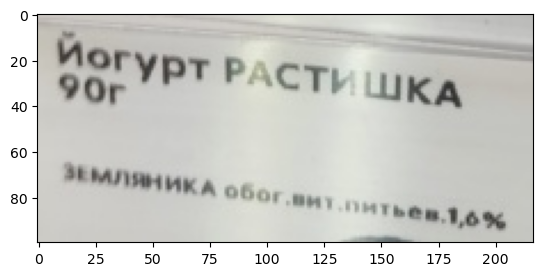

In [ ]:
for file_path in tqdm(all_files[100:110], desc="Process images", unit="image"):
    print(file_path)
    img = mpimg.imread(file_path)
    plt.imshow(img)
    plt.show() 
    result = predict(file_path)
    print(result)
    corrected_result = phrase_corrector.correct_words_in_text(result)
    print(corrected_result)
   